In [1]:
import pickle

with open('elvish-names.pickle', "rb") as file:
    names = pickle.load(file)

In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab
from collections import Counter

class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.specials = ['<pad>', '<bos>', '<eos>']
        counter = Counter(''.join(names))
        self.vocab = Vocab(counter, specials=self.specials)
        self.pad_index = self.vocab['<pad>']
        self.bos_index = self.vocab['<bos>']
        self.eos_index = self.vocab['<eos>']
        self.max_len = max(len(name) for name in names) + 2

    def __len__(self):
        return len(self.names)

    def str_to_idx(self, chars):
        return [self.vocab[char] for char in chars]
    
    def idx_to_str(self, idx):
        return [self.vocab.itos[index] for index in idx]
    
    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)
        
    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __getitem__(self, item):
        encoded = self.encode(self.names[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

In [10]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

class Generator(nn.Module):
    def __init__(self, dataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(dataset.vocab), embedding_dim=embed_dim)
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(dataset.vocab))
        self.dataset = dataset
        self.max_len = dataset.max_len if max_len is None else max_len
    
    def forward(self, tokens, lengths):
        embeds = self.embedding(tokens)
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        output, hidden = self.rnn(packed_embeds)
        output, lengths = pad_packed_sequence(output, batch_first=True)
        logits = self.linear(output)
        return logits
    
    @torch.no_grad()
    def inference(self, prefix=''):
        tokens = self.dataset.encode(prefix)[:-1]
        tokens = torch.tensor(tokens).unsqueeze(0)
        
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)
        
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)
        
        return self.dataset.decode(tokens.squeeze())

In [11]:
dataset = NamesDataset(names)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [40]:
model = Generator(dataset, embed_dim=32, hidden_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_index)

In [41]:
[model.inference('') for _ in range(10)]

['shqrwwqg',
 'jxgolwrzogihne',
 'oo',
 'kjsnyoonbzlyn',
 'jagk',
 'oebh',
 'cxdngaajvhoiwx',
 'ywhr',
 'ogkvfqnlaaowo',
 'lurlfgixjqosit']

In [34]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.show()

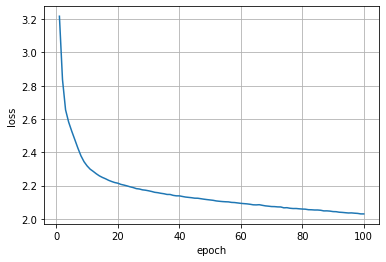

In [42]:
losses = []
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for tokens, lengths in dataloader:
        tokens = tokens[:, :lengths.max()]
        optimizer.zero_grad()
        logits = model(tokens[:, :-1], lengths - 1)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * tokens.shape[0]
    
    losses += [running_loss / len(dataset)]
    
    if epoch % 10 == 0:
        plot_losses(losses)

In [53]:
[model.inference('') for _ in range(10)]

['uuighantha',
 'hylorter',
 'nuis',
 'lleanniw',
 'diwelnarin',
 'tharot',
 'alyundel',
 'vyk',
 'aulym',
 'onsisthel']